  #  Assignment No. 3
   
### Vishwajeet Bhosale 

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [2]:
!pip3 install torch

You should consider upgrading via the '/usr/local/python-env/py36/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [4]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        #self.gpu = use_gpu

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=False):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        '''
        if self.gpu:
            X = X.to('cuda')
            T = T.to('cuda')
        '''
        
        for epoch in range(n_epochs):

            Y = self.forward(X)
    
            mse = mse_func(T, Y)
            mse.backward()
    
            optimizer.step() 
            optimizer.zero_grad()
            
            #unst_mse = mse 
            self.error_trace.append(mse)
            
            if verbose == True and  (epoch + 1) % max(1, 5) == 0 :
                print(f'Epoch {epoch + 1} : RMSE {(((np.sqrt(mse.detach())) * self.Tstds) )[0]}')
            
            
            

    def use(self, X):
 
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        # Standardize X
        X = (X - self.Xmeans) / self. Xstds
        
        #if self.gpu:
        #    X = X.to('cuda')
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        y_std = self.forward(X)
        
        Y = (y_std * self.Tstds) + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
        return Y.cpu().detach().numpy()


## Example

In [5]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01, True)
Y = net.use(X)


def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))


print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5 : RMSE 11.155450820922852
Epoch 10 : RMSE 6.06194543838501
Epoch 15 : RMSE 5.169205665588379
Epoch 20 : RMSE 2.1026830673217773
Epoch 25 : RMSE 2.3169872760772705
Epoch 30 : RMSE 2.6357510089874268
Epoch 35 : RMSE 1.4629969596862793
Epoch 40 : RMSE 1.1365954875946045
Epoch 45 : RMSE 1.1702879667282104
Epoch 50 : RMSE 0.9215653538703918
RMSE 0.867


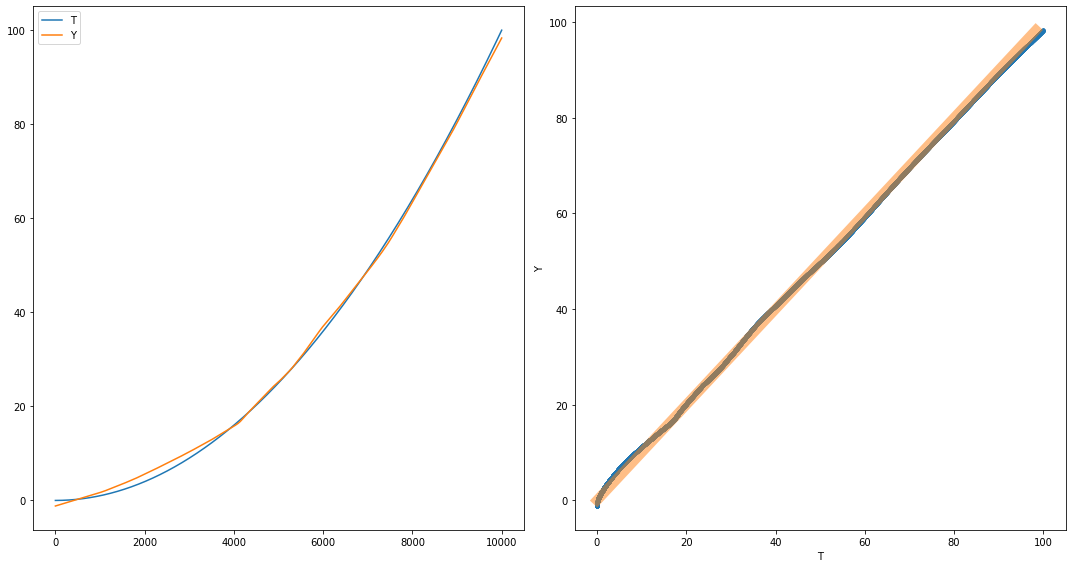

In [6]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [7]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [8]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [9]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [10]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func, gpu=False):
    
    train_rmse_list = []
    test_rmse_list = []
    tval_rmse_list = []
    
    avg_list = []
    
    def rmse_new(Y, T):
                    
        T = T.cpu().detach()
        T = np.array(T)
        #print(type(T), type(Y))
        #print((T), (Y))

        return np.sqrt(np.mean((T - Y)**2))
    
    for n_hiddens in list_of_n_hiddens:
                                   
        train_rmse_list = []
        test_rmse_list = []
        tval_rmse_list = []
        
        for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):

                
                n_samples, n_inputs = Xtrain.shape 
                n_outputs = Ttrain.shape[1]

                
                
                net = NNet(n_inputs, n_hiddens, n_outputs, act_func=act_func)
                
                Xtrain = torch.from_numpy(Xtrain).float()
                Ttrain = torch.from_numpy(Ttrain).float()
                Xtest = torch.from_numpy(Xtest).float()
                Ttest = torch.from_numpy(Ttest).float()
                Xval = torch.from_numpy(Xval).float()
                Tval = torch.from_numpy(Tval).float()

                

                
                if gpu:
                    
                    
                    
                    Xtrain = Xtrain.to('cuda')
                    Ttrain = Ttrain.to('cuda')
                    Xval = Xval.to('cuda')
                    Tval = Tval.to('cuda')
                    Xtest = Xtest.to('cuda')
                    Ttest = Ttest.to('cuda')
                    net.to('cuda')

                    
                net.train(Xtrain, Ttrain, n_epochs, learning_rate, False)
                
                #Train RMSE
                Ytrain = net.use(Xtrain)
                train_rmse = rmse_new(Ytrain, Ttrain)

                #print(f'Train RMSE {rmse(Ytrain, Ttrain):.3f}')
                
                #Test RMSE
                Ytest = net.use(Xtest)
                test_rmse = rmse_new(Ytest, Ttest)

                #print(f'Test RMSE {rmse(Ytest, Ttest):.3f}')
                
                #Validation RMSE
                Yval = net.use(Xval)
                tval_rmse = rmse_new(Yval, Tval)

                #print(f'Train RMSE {rmse(Yval, Tval):.3f}')
                
                train_rmse_list.append(train_rmse)
                test_rmse_list.append(test_rmse)
                tval_rmse_list.append(tval_rmse)
                
               
        
        avg_train = sum(train_rmse_list)/len(train_rmse_list)
        avg_test = sum(test_rmse_list)/len(test_rmse_list)
        avg_tval = sum(tval_rmse_list)/len(tval_rmse_list)
        
        
        
        
        avg_list.append((n_hiddens, avg_train, avg_test, avg_tval))

        
    result_df = pandas.DataFrame(avg_list, columns=['Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'])
    
    
    return result_df

In [11]:
rdf = run_k_fold_cross_validation(X, T, 3, [[], [1], [5], [200, 200]], 50, 0.01, 'relu')
rdf

,Arch,Train RMSE,Validate RMSE,Test RMSE
0,[],2.658026,9.553700,5.898616
1,[1],14.174273,15.164413,18.588867
2,[5],0.664949,4.468110,4.779950
3,"[200, 200]",0.266453,2.009241,2.478226


## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [12]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [13]:
airfoil.head

<bound method NDFrame.head of       frequency  angle   chord  velocity  thickness  pressure
0           800    0.0  0.3048      71.3   0.002663   126.201
1          1000    0.0  0.3048      71.3   0.002663   125.201
2          1250    0.0  0.3048      71.3   0.002663   125.951
3          1600    0.0  0.3048      71.3   0.002663   127.591
4          2000    0.0  0.3048      71.3   0.002663   127.461
...         ...    ...     ...       ...        ...       ...
1498       2500   15.6  0.1016      39.6   0.052849   110.264
1499       3150   15.6  0.1016      39.6   0.052849   109.254
1500       4000   15.6  0.1016      39.6   0.052849   106.604
1501       5000   15.6  0.1016      39.6   0.052849   106.224
1502       6300   15.6  0.1016      39.6   0.052849   104.204

[1503 rows x 6 columns]>

In [14]:
data = airfoil.iloc[:, :].values

X = data[:, :5]
T = data[:, 5:6]


In [15]:
T[0]

array([126.201])

In [16]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Took 0.00 hours


,Arch,Train RMSE,Validate RMSE,Test RMSE
0,[],4.790511,4.840742,4.839218
1,[1],4.519531,4.544003,4.550374
2,[5],3.945289,4.056473,4.075281
3,"[200, 200]",1.226905,1.800480,1.818607


Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [17]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

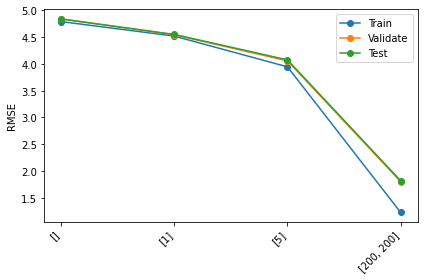

In [18]:
plot_results(results)

In [ ]:
# Testing with different NNet archs

n_folds = 5 
list_of_n_hiddens = [[[], [10], [50], [200, 200], [50,100,50], [200,400,500]], [[10], [50,50,50,50], [100, 100, 200, 200] ]]
n_epochs = 1000
learning_rate =  0.01, 0.1, 1
act_func = ['relu', 'tanh']

torch.manual_seed(42)
np.random.seed(42)


start = time.time()

results1 = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[0], 
                                n_epochs, learning_rate[0], act_func[0])
                  


elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results1

Activation function - 


,Arch,Train RMSE,Validate RMSE,Test RMSE
0,[],4.788779,4.837913,4.837913
1,[10],2.532805,2.771846,2.738732
2,[50],1.565838,2.059607,2.069478
3,"[200, 200]",0.669355,1.599807,1.612388
4,"[50, 100, 50]",0.548254,1.526049,1.527779
5,"[200, 400, 500]",0.568004,1.512912,1.511016


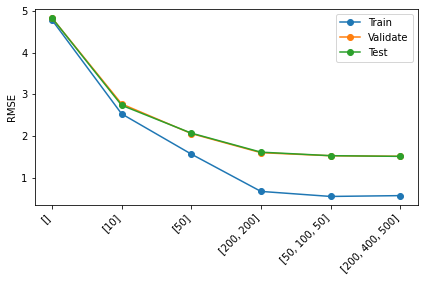

In [34]:
print('Activation function - relu')
plot_results(results1)
results1

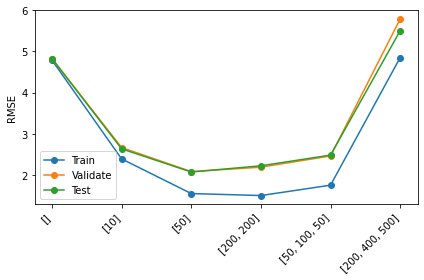

In [35]:
results2 = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[0], 
                                n_epochs, learning_rate[1], act_func[0])


print('Activation function - relu')
plot_results(results2)
results2

 
 Activation function - tanh


,Arch,Train RMSE,Validate RMSE,Test RMSE
0,[],4.788873,4.832893,4.832892
1,[10],2.332762,2.549530,2.559662
2,[50],1.491545,1.967507,1.978619
3,"[200, 200]",0.387732,1.679182,1.696056
4,"[50, 100, 50]",0.430861,1.439744,1.463069
5,"[200, 400, 500]",0.548711,1.666065,1.662622


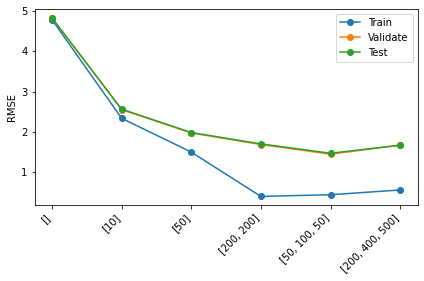

In [42]:
results3 = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[0], 
                                n_epochs, learning_rate[0], act_func[1])
print(' \n Activation function - tanh')
plot_results(results3)
results3

 
 Activation function - tanh


,Arch,Train RMSE,Validate RMSE,Test RMSE
0,[10],2.328001,2.587305,2.599411
1,"[50, 50, 50, 50]",0.562171,1.409013,1.414969
2,"[100, 100, 200, 200]",0.357686,1.484978,1.465208


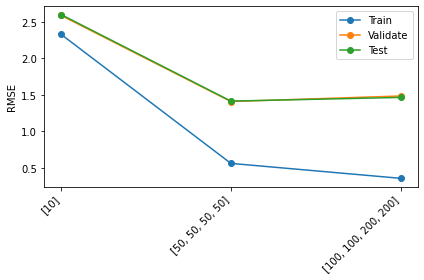

In [41]:
results4 = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[1], 
                                n_epochs, learning_rate[0], act_func[1])
print(' \n Activation function - tanh')
plot_results(results4)
results4  

 ## Discussion
 
- Lowest validation RMSE is 1.40 with config [50,50,50,50]


- Learning rate of 0.01 seems to be the best suited for the data given. If learning rate is further increase the RMSE goes up 


- As we increse the number of hidden layers and the number of neurons in hidden layers, RMSE goes down up to a point ( 3 or 4 layers and 50 to 100 neurons in each layer). After this point the RMSE does not go down that much


- This migh be beacuse the data we have has only 5 input features and we are predicting only one thing. So the relationship between features and the output is not very complex. Therefore, NN with 4 layers might be enough to take care of the nonlinearities


- Testing and Validation RMSE is similar. This might be due to similar size of test and validation datasets after the 5 fold split


- The model starts to overfit after about 4 layers


- Training time increases rapidly with increase in number of hidden layers and number of neurons in them


- Selection of activation function did not have that much of impact on RMSE. I got similar results for tanh and relu activation function


# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [28]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A3.3 Cross-validation with Pytorch.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
  

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).

In [21]:
torch.cuda.is_available()


True

In [23]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))
data = airfoil.iloc[:, :].values

X = data[:, :5]
T = data[:, 5:6]


torch.manual_seed(42)
np.random.seed(42)

n_folds = 5 
list_of_n_hiddens = [[[], [10], [50], [200, 200], [50,100,50], [200,400,500]], [[10], [50,50,50,50], [100, 100, 200, 200] ]]
n_epochs = 1000
learning_rate =  0.01, 0.1, 1
act_func = ['relu', 'tanh']


In [27]:
# without GPU
gpu = False

# 1st parameter combination
start = time.time()
results_gpu = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[0], 
                            n_epochs, learning_rate[0], act_func[0], gpu)
elapsed = (time.time() - start) / 60/ 60
print(f'CPU Took {elapsed:.2f} hours with architecture-{list_of_n_hiddens[0]}, activation function -{act_func[0]}, learning rate - {learning_rate[0]}')


# 2nd parameter combination
n_epochs = 1500
start = time.time()
results_gpu = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[1], 
                            n_epochs, learning_rate[1], act_func[1], gpu)
elapsed = (time.time() - start) / 60/ 60
print(f'CPU Took {elapsed:.2f} hours with architecture-{list_of_n_hiddens[1]}, activation function -{act_func[1]}, learning rate - {learning_rate[1]}')




# with GPU
gpu = True

if gpu:

    n_epochs = 1000
    start = time.time()
    results_gpu = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[0], 
                                n_epochs, learning_rate[0], act_func[0], gpu)
    elapsed = (time.time() - start) / 60/ 60 
    print(f'GPU (CUDA) Took {elapsed:.2f} hours with architecture-{list_of_n_hiddens[0]}, activation function -{act_func[0]}, learning rate - {learning_rate[0]}')

    n_epochs = 1500
    start = time.time()
    results_gpu = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens[1], 
                                n_epochs, learning_rate[1], act_func[1], gpu)
    elapsed = (time.time() - start) / 60/ 60 
    print(f'GPU (CUDA) Took {elapsed:.2f} hours with architecture-{list_of_n_hiddens[1]}, activation function -{act_func[1]}, learning rate - {learning_rate[1]}')

    
    results_gpu

CPU Took 0.09 hours with architecture-[[], [10], [50], [200, 200], [50, 100, 50], [200, 400, 500]], activation function -relu, learning rate - 0.01
CPU Took 0.06 hours with architecture-[[10], [50, 50, 50, 50], [100, 100, 200, 200]], activation function -tanh, learning rate - 0.1
GPU (CUDA) Took 0.05 hours with architecture-[[], [10], [50], [200, 200], [50, 100, 50], [200, 400, 500]], activation function -relu, learning rate - 0.01
GPU (CUDA) Took 0.07 hours with architecture-[[10], [50, 50, 50, 50], [100, 100, 200, 200]], activation function -tanh, learning rate - 0.1


 ## Discussion 
 
 - As seen from the output above. Using GPU (CUDA) does not speed up the operation significantly
 - This might be due to the small size of the dataset. As the speedup due to faster computation in GPU might be cancelled out by the overhead of loading data from memory to GPU (CUDA)
 - If tested with larger dataset, we might get significant improvements in time